In [4]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)

import requests
import folium
from folium.plugins import FastMarkerCluster, Fullscreen, MiniMap, HeatMap, HeatMapWithTime, LocateControl

import json
import requests

from collections import Counter
from PIL import Image
from scipy import stats 

#Plotly Libraries

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.colors import n_colors
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

# Data Description

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allow viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. There is also a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data which has been anonymised.

# Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. 

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

# Data Science Problem Statement

Through this dataset, I will use various machine learning methods to predict -  

1) Segmentation - How can customers be clustered based on their purchase habits?   
2) Customer Lifetime Value - How much will a customer bring in future revenue?  
3) Churn - Which customers will not remain with Olist?  

# Imports

In [5]:
# Reading data:
customers = pd.read_csv("./datasets/olist/olist_customers_dataset.csv")
geoloc = pd.read_csv("./datasets/olist/olist_geolocation_dataset.csv")
items = pd.read_csv("./datasets/olist/olist_order_items_dataset.csv")
payments = pd.read_csv("./datasets/olist/olist_order_payments_dataset.csv")
reviews = pd.read_csv("./datasets/olist/olist_order_reviews_dataset.csv")
orders = pd.read_csv("./datasets/olist/olist_orders_dataset.csv")
products = pd.read_csv("./datasets/olist/olist_products_dataset.csv")
sellers = pd.read_csv("./datasets/olist/olist_sellers_dataset.csv")
category = pd.read_csv("./datasets/olist/product_category_name_translation.csv")

In [6]:
df1 = items.merge(payments, on='order_id')
print(df1.shape)
df2 = df1.merge(products, on='product_id')
print(df2.shape)
df3 = df2.merge(sellers, on='seller_id')
print(df3.shape)
df4 = df3.merge(reviews, on='order_id')
print(df4.shape)
df5 = df4.merge(orders, on='order_id')
print(df5.shape)
df6 = df5.merge(category, on='product_category_name')
print(df6.shape)
Olist = df5.merge(customers, on='customer_id')
print(Olist.shape)

(117601, 11)
(117601, 19)
(117601, 22)
(118315, 28)
(118315, 35)
(116581, 36)
(118315, 39)


# Data Cleaning and Feature Engineering

In [7]:
mapping = dict(zip(category['product_category_name'], category['product_category_name_english']))

In [8]:
Olist['product_category_name'].replace(mapping, inplace=True)

In [9]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp', 'order_estimated_delivery_date']
for col in date_columns:
    Olist[col] = pd.to_datetime(Olist[col], format='%Y-%m-%d %H:%M:%S')

In [11]:
# cleaning up name columns, and engineering new/essential columns
Olist['customer_city'] = Olist['customer_city'].str.title()
Olist['seller_city'] = Olist['seller_city'].str.title()
Olist['product_category_name'] = Olist['product_category_name'].str.title()
Olist['payment_type'] = Olist['payment_type'].str.replace('_', ' ').str.title()
Olist['product_category_name'] = Olist['product_category_name'].str.replace('_', ' ')
Olist['review_response_time'] = (Olist['review_answer_timestamp'] - Olist['review_creation_date']).dt.days
Olist['order_purchase_year'] = Olist.order_purchase_timestamp.apply(lambda x: x.year)
Olist['order_purchase_month'] = Olist.order_purchase_timestamp.apply(lambda x: x.month)
Olist['order_purchase_dayofweek'] = Olist.order_purchase_timestamp.apply(lambda x: x.dayofweek)
Olist['order_purchase_hour'] = Olist.order_purchase_timestamp.apply(lambda x: x.hour)
Olist['order_purchase_day'] = Olist['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
Olist['order_purchase_mon'] = Olist.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
Olist['order_purchase_year_month'] = Olist['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y%m'))

In [12]:
#save clean DF
Olist.to_csv('./datasets/Olist_master.csv', index = False)

# Data Visualizations

Text(0, 0.5, 'Product category')

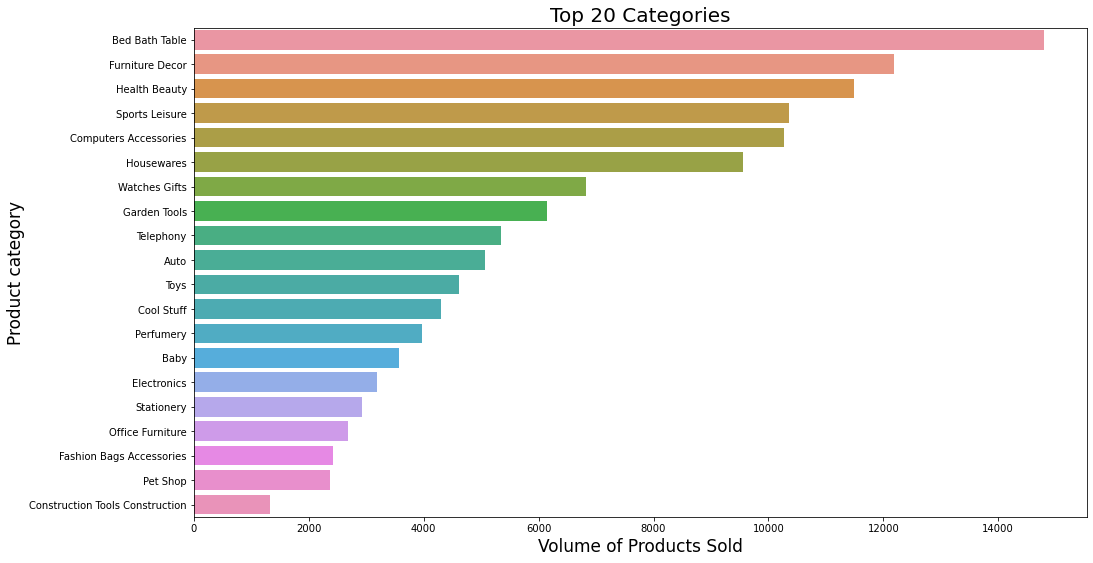

In [13]:
#Crosstab of the top 20 best selling categories in the whole DF
top_20_product_best_seller = Olist['order_item_id'].groupby(Olist['product_category_name']).sum().sort_values(ascending=False)[:20]


#Visualizing via bar chart
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_product_best_seller.index,x=top_20_product_best_seller.values)
plt.title('Top 20 Categories',fontsize=20)
plt.xlabel('Volume of Products Sold',fontsize=17)
plt.ylabel('Product category',fontsize=17)

Text(0, 0.5, 'City')

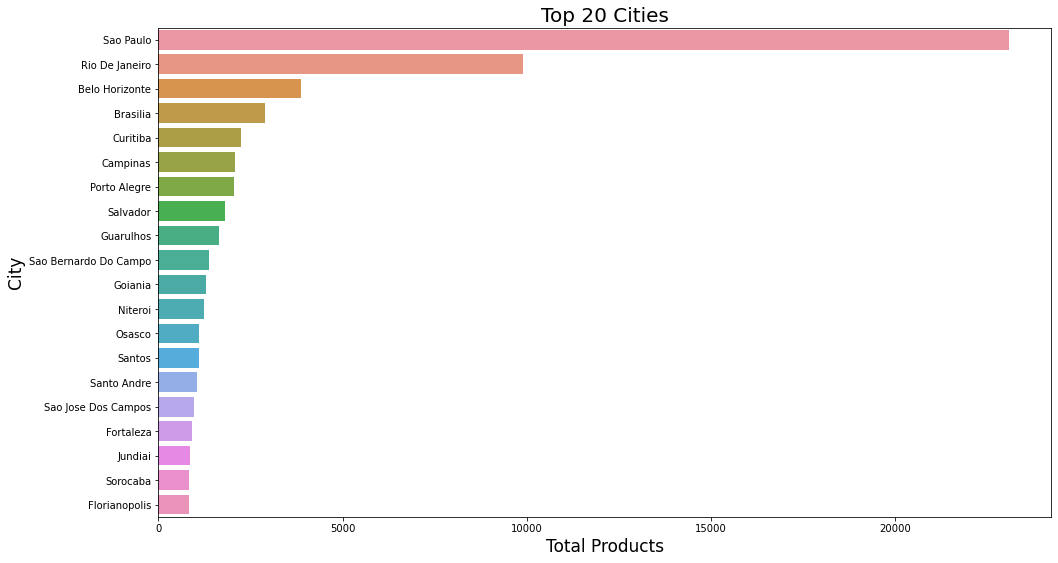

In [14]:
#Top 20 cities
top_20_city_shopping = Olist['order_item_id'].groupby(Olist['customer_city']).sum().sort_values(ascending=False)[:20]
#print(top_20_city_shopping)

#Visualize
fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_20_city_shopping.index,x=top_20_city_shopping.values)
plt.title('Top 20 Cities',fontsize=20)
plt.xlabel('Total Products',fontsize=17)
plt.ylabel('City',fontsize=17)

Text(0, 0.5, 'Customer ID')

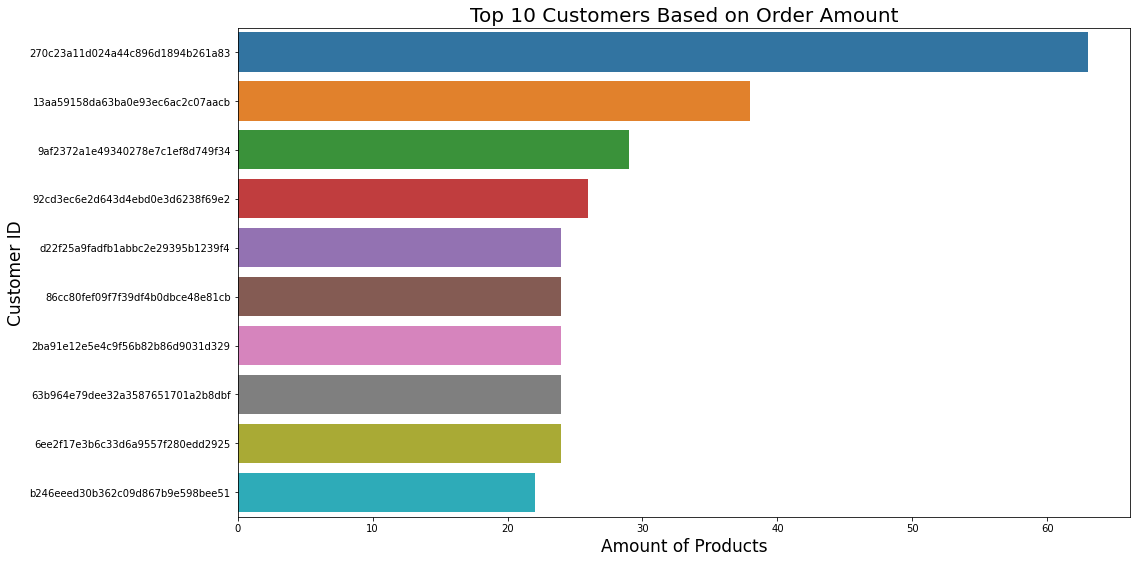

In [16]:
#Top 10 customer IDs
top_10_customer_shopping = Olist['order_item_id'].groupby(Olist['customer_id']).count().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customers Based on Order Amount',fontsize=20)
plt.xlabel('Amount of Products',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

Text(0, 0.5, 'Customer ID')

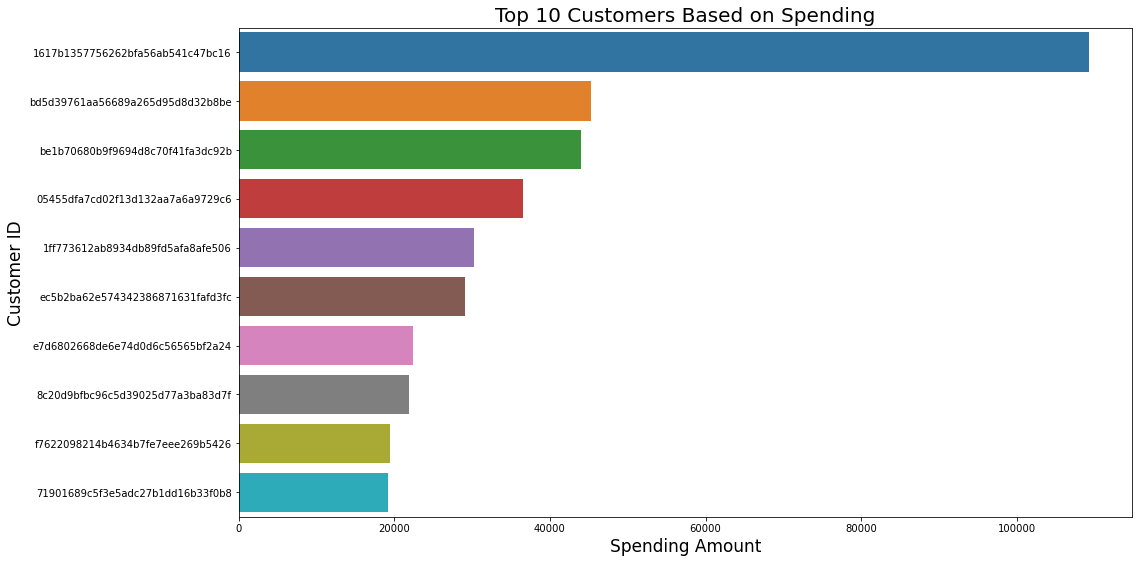

In [17]:
#Top 10 customers - based on amount spent
top_10_customer_shopping = Olist['payment_value'].groupby(Olist['customer_id']).sum().sort_values(ascending=False)[:10]
#print(top_10_customer_shopping)

fig=plt.figure(figsize=(16,9))
sns.barplot(y=top_10_customer_shopping.index,x=top_10_customer_shopping.values)
plt.title('Top 10 Customers Based on Spending',fontsize=20)
plt.xlabel('Spending Amount',fontsize=17)
plt.ylabel('Customer ID',fontsize=17)

In [26]:
df_orders = orders.merge(customers, how='left', on='customer_id')

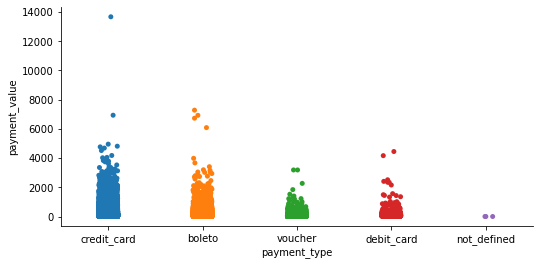

In [19]:
ax = sns.catplot(x="payment_type", y="payment_value",data=payments, aspect=2, height=3.8)

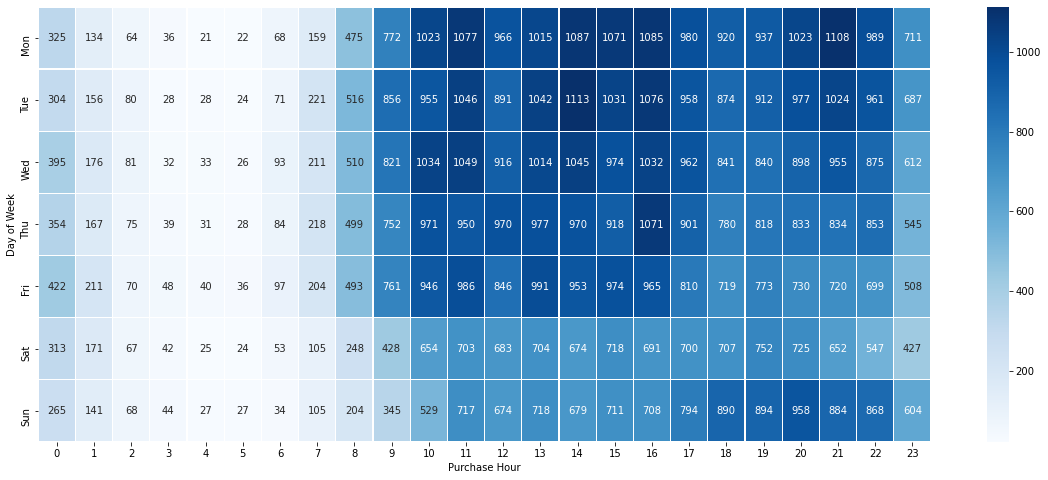

In [20]:
purchase_count = Olist.groupby(['order_purchase_day', 'order_purchase_hour']).nunique()['order_id'].unstack()
plt.figure(figsize=(20,8))
sns.heatmap(purchase_count.reindex(index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']), annot=True, cmap = 'Blues', fmt="d", linewidths=0.2)
plt.xlabel('Purchase Hour')
plt.ylabel('Day of Week')
plt.show()

In [21]:
# creating a purchase day feature
df = Olist.copy()
# creating an aggregation
sales_per_purchase_month = Olist.groupby(['order_purchase_month', 'order_purchase_mon', 'order_purchase_day'], as_index=False).payment_value.sum()
sales_per_purchase_month = sales_per_purchase_month.sort_values(by=['order_purchase_month'], ascending=True)

In [22]:
import plotly.express as px

df = sales_per_purchase_month
fig = px.line(df, x="order_purchase_mon", y="payment_value", color='order_purchase_day', title='Sales Each Month & Each DayofWeek')

fig.update_layout(
    title="Sales by Month and Day of the Week",
    xaxis_title="Month",
    yaxis_title="Sales(in USD$)",
)
fig.show()

In [35]:
monthly_orders = pd.DataFrame(Olist.groupby(['order_purchase_mon'])['order_purchase_mon'].count())

In [36]:
monthly_orders = monthly_orders.rename(index={1: 'January', 2: 'February', 3: 'March', 4: 'April', 5:'May', 6:'June', 7:'July',8:'August', 9:'September', 10:'October', 11:'November', 12:'December'})

In [38]:
cats = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']
monthly_orders.index = pd.CategoricalIndex(monthly_orders.index, categories=cats, ordered=True)
monthly_orders = monthly_orders.sort_index()

In [40]:
fig = go.Figure(data=go.Scatter(x=monthly_orders.index,
                                y=monthly_orders['order_purchase_mon'],
                                mode='lines+markers')) # hover text goes here
fig.update_layout(title='Months With Most Orders',xaxis_title="Month",yaxis_title="Number of Orders")
fig.update_yaxes(type="log")
fig.show()

In [41]:
Olist['review_dayofweek'] = Olist.review_answer_timestamp.apply(lambda x: x.dayofweek)
Olist['review_day'] = Olist['review_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
Olist['review_month'] = Olist.review_answer_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

In [42]:
# creating a purchase day feature
df = Olist.copy()
# creating an aggregation
#sales_per_purchase_month = Olist.groupby(['order_purchase_month', 'order_purchase_mon', 'order_purchase_day'], as_index=False).payment_value.sum()
#sales_per_purchase_month = sales_per_purchase_month.sort_values(by=['order_purchase_month'], ascending=True)

review_score_per_month = Olist.groupby(['review_month', 'review_day'], as_index=False).review_score.mean()
#review_score_per_month = review_score_per_month.sort_values(by=['review_day'], ascending=True)
review_score_per_month

,review_month,review_day,review_score
0,Apr,Fri,3.823216
1,Apr,Mon,3.742225
2,Apr,Sat,3.836775
3,Apr,Sun,3.821579
4,Apr,Thu,3.861064
...,...,...,...
79,Sep,Sat,4.272429
80,Sep,Sun,4.137987
81,Sep,Thu,4.168605
82,Sep,Tue,4.141903


In [43]:

df = review_score_per_month
fig = px.line(df, x="review_month", y="review_score", color='review_day', title='Sales Each Month & Each DayofWeek')

fig.update_layout(
    title="Ratings by month and day of week",
    xaxis_title="Month",
    yaxis_title="Review Ratings",
    #font=dict(
     #   family="Courier New, monospace",
      #  size=15,
       # color="#7f7f7f"
    #)
)
fig.show()

In [44]:
# creating an aggregation
avg_score_per_category = Olist.groupby('product_category_name', as_index=False).agg({'review_score': ['count', 'mean']})
avg_score_per_category.columns = ['Product Category', 'Number of Reviews', 'Average Review Rating']

# filtering to show only categories with more than 50 reviews
avg_score_per_category = avg_score_per_category[avg_score_per_category['Number of Reviews'] > 100]
avg_score_per_category = avg_score_per_category.sort_values(by='Number of Reviews', ascending=False)
avg_score_per_category

,Product Category,Number of Reviews,Average Review Rating
7,Bed Bath Table,11990,3.867056
43,Health Beauty,10030,4.119143
67,Sports Leisure,9005,4.092837
39,Furniture Decor,8833,3.895279
15,Computers Accessories,8151,3.926144
49,Housewares,7380,4.045257
72,Watches Gifts,6213,4.000644
70,Telephony,4726,3.938214
42,Garden Tools,4590,4.011329
5,Auto,4400,4.038636


In [45]:
avg_ratings = avg_score_per_category[:20]
fig = px.bar(avg_ratings, x='Product Category', y='Number of Reviews',
             hover_data=['Average Review Rating'], color='Average Review Rating',
             height=500)
fig.show()

In [46]:
sales_per_category = Olist.groupby(['order_purchase_month', 'product_category_name'], as_index=False).payment_value.sum()
sales_per_category = sales_per_category.sort_values(by=['payment_value'], ascending=False)
sales_per_category.columns = ['Purchase Month','Product Category', 'Sales Revenue']
sales_per_category

,Purchase Month,Product Category,Sales Revenue
81,2,Computers Accessories,227799.07
520,8,Health Beauty,221325.17
414,7,Bed Bath Table,202002.66
312,5,Health Beauty,198350.77
449,7,Health Beauty,197035.68
...,...,...,...
623,10,Cds Dvds Musicals,61.11
641,10,Fashion Childrens Clothes,54.09
304,5,Flowers,35.72
203,4,Arts And Craftmanship,34.22


In [47]:
df = sales_per_category
fig = px.bar(df, y='Sales Revenue', x='Product Category', text='Sales Revenue', hover_data=['Purchase Month'])
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(barmode='stack',uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [67]:
total_rev_year = Olist.groupby(['order_purchase_year'], as_index=False).payment_value.sum()
#total_rev_year = total_rev_year[total_rev_year['order_purchase_year']== 2018]
total_rev_year

,order_purchase_year,payment_value
0,2016,75140.68
1,2017,9229786.14
2,2018,11113361.33


In [68]:
total_orders = Olist.groupby(['order_purchase_year'], as_index=False).order_id.nunique()
total_orders

0      311
1    44579
2    53775
Name: order_id, dtype: int64

In [69]:
total_category = Olist.product_category_name.nunique()
total_category

73

In [70]:
total_customers = Olist.customer_unique_id.nunique()
total_customers

95419

In [72]:
total_rev_month = Olist.groupby(['order_purchase_year', 'order_purchase_mon', 'product_category_name'], as_index=False).payment_value.sum()
#total_rev_month = total_rev_month.sort_values(by=['order_purchase_year'], ascending=True)
total_rev_month.columns = ['Sales Year','Sales Month','Product Category' , 'Sales Revenue']
total_rev_month

,Sales Year,Sales Month,Product Category,Sales Revenue
0,2016,Dec,Fashion Bags Accessories,19.62
1,2016,Oct,Air Conditioning,4675.43
2,2016,Oct,Audio,183.03
3,2016,Oct,Auto,2716.70
4,2016,Oct,Baby,2344.43
...,...,...,...,...
1256,2018,May,Tablets Printing Image,58.19
1257,2018,May,Telephony,27718.21
1258,2018,May,Toys,38166.71
1259,2018,May,Watches Gifts,150688.81


In [81]:

import plotly.graph_objects as go

df = Olist[Olist.order_purchase_year == 2018]
sales_per_category = df.groupby(['product_category_name'], as_index=False).payment_value.sum()
sales_per_category = sales_per_category.sort_values(by=['payment_value'], ascending=False)
sales_per_category.columns = ['Product Category', 'Sales Revenue']

sales_per_category = sales_per_category[:20]
labels = sales_per_category['Product Category']
values = sales_per_category['Sales Revenue']

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Bar(x=labels, y=values)])
fig.show()

In [84]:
total_rev_hour = Olist[Olist['order_purchase_year'] == 2018].groupby(['order_purchase_hour', 'product_category_name'], as_index=False).payment_value.sum()
#total_rev_month = total_rev_month.sort_values(by=['order_purchase_year'], ascending=True)
total_rev_hour.columns = ['Sales Hour','Product Category' , 'Sales Revenue']
total_rev_hour

,Sales Hour,Product Category,Sales Revenue
0,0,Agro Industry And Commerce,610.22
1,0,Air Conditioning,1801.40
2,0,Art,1206.29
3,0,Audio,587.91
4,0,Auto,7175.56
...,...,...,...
1331,23,Stationery,6965.88
1332,23,Tablets Printing Image,129.32
1333,23,Telephony,9735.20
1334,23,Toys,6869.96


In [85]:
labels = total_rev_hour['Sales Hour']
values = total_rev_hour['Sales Revenue']

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Bar(x=labels, y=values)])
fig.show()

In [86]:
total_rev_hour = Olist[Olist['order_purchase_year'] == 2018].groupby(['order_purchase_day', 'product_category_name'], as_index=False).payment_value.sum()
#total_rev_month = total_rev_month.sort_values(by=['order_purchase_year'], ascending=True)
total_rev_hour.columns = ['Sales DayofWeek','Product Category' , 'Sales Revenue']
total_rev_hour

,Sales DayofWeek,Product Category,Sales Revenue
0,Fri,Agro Industry And Commerce,5839.40
1,Fri,Air Conditioning,5826.38
2,Fri,Art,2398.56
3,Fri,Arts And Craftmanship,408.95
4,Fri,Audio,4834.79
...,...,...,...
466,Wed,Stationery,33990.66
467,Wed,Tablets Printing Image,263.43
468,Wed,Telephony,61517.25
469,Wed,Toys,34728.87


In [87]:
labels = total_rev_hour['Sales DayofWeek']
values = total_rev_hour['Sales Revenue']

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Bar(x=labels, y=values)])
fig.show()

In [88]:
df = total_rev_hour
fig = px.sunburst(df, path=['Sales DayofWeek', 'Product Category'], values='Sales Revenue',
                  color='Sales Revenue', hover_data=['Product Category'],
                  color_continuous_scale='RdBu',
                  color_continuous_midpoint=np.average(df['Sales Revenue'], weights=df['Sales Revenue']))
fig.show()

In [41]:
average_price = Olist.groupby("product_category_name")["price"].agg(np.mean).sort_values().tail(10)


print('Top 10 categories with highest average price.')
print('-----------------------------------------------')
print(average_price.sort_values(ascending=False))

Top 10 categories with highest average price.
-----------------------------------------------
product_category_name
Computers                                        1103.689136
Small Appliances Home Oven And Coffee             627.509103
Home Appliances 2                                 457.390258
Agro Industry And Commerce                        332.706151
Musical Instruments                               293.398651
Small Appliances                                  286.297248
Portateis Cozinha E Preparadores De Alimentos     264.568667
Fixed Telephony                                   226.989890
Construction Tools Safety                         210.942261
Watches Gifts                                     201.886842
Name: price, dtype: float64


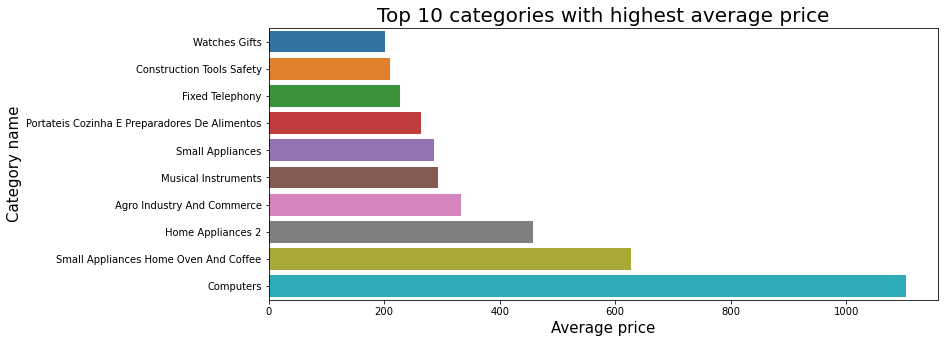

In [43]:
# Top 10 categories with highest average price.
fig=plt.figure(figsize=(12,5))
#sns.set_style("darkgrid")
sns.barplot(y=average_price.index, x=average_price.values)
plt.title('Top 10 categories with highest average price',fontsize=20);
plt.xlabel('Average price',fontsize=15);
plt.ylabel('Category name',fontsize=15);

In [44]:
# Avergae prices of Top 10 frequently repeated categories
top_10_category = Olist["product_category_name"].value_counts().head(10)
top_category = Olist[Olist['product_category_name'].isin(top_10_category.index)]
price_top_category=round(top_category.groupby("product_category_name")["price"].agg(np.mean).sort_values(ascending=False), 2)


print('Avergae prices of Top 10 frequently repeated categories')
print('--------------------------------------------------------')
print(price_top_category.sort_values(ascending=False))

Avergae prices of Top 10 frequently repeated categories
--------------------------------------------------------
product_category_name
Watches Gifts            201.89
Auto                     140.54
Health Beauty            129.80
Computers Accessories    116.57
Sports Leisure           114.34
Garden Tools             113.18
Bed Bath Table            92.36
Housewares                90.63
Furniture Decor           87.46
Telephony                 71.85
Name: price, dtype: float64


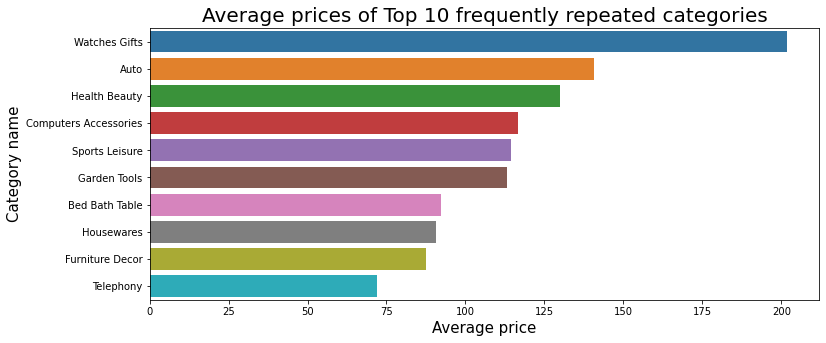

In [46]:
fig=plt.figure(figsize=(12,5))
sns.barplot(y=price_top_category.index, x=price_top_category.values)
plt.title('Average prices of Top 10 frequently repeated categories',fontsize=20);
plt.xlabel('Average price',fontsize=15);
plt.ylabel('Category name',fontsize=15);

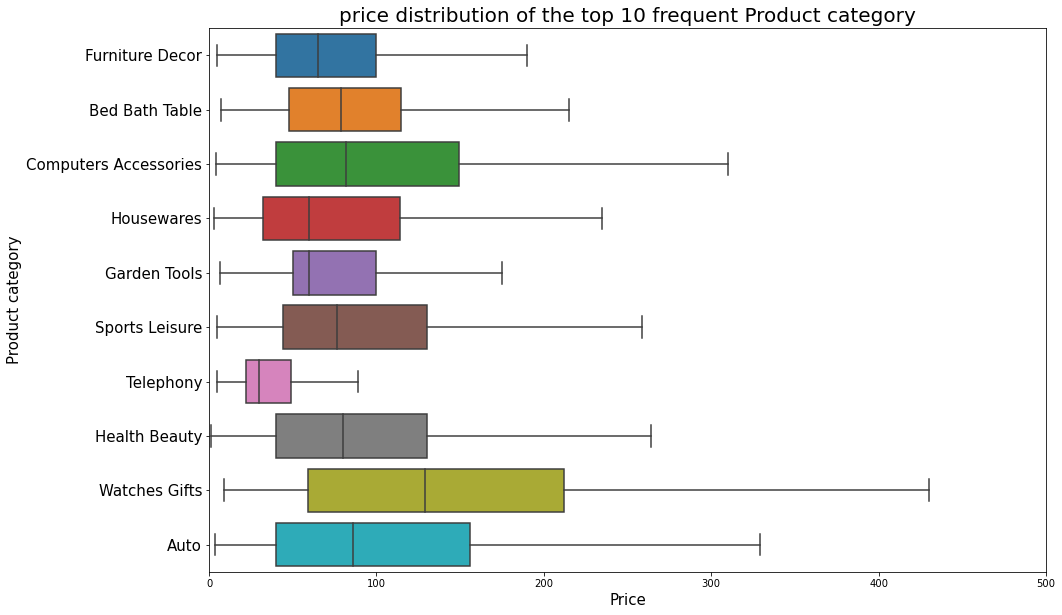

In [48]:
fig=plt.figure(figsize=(15,10))

sns.boxplot(data=top_category,x='price',y='product_category_name',
           showfliers=False);
plt.xlim(0,500);
plt.title('price distribution of the top 10 frequent Product category',fontsize=20)


plt.ylabel('Product category',fontsize=15)
plt.xlabel('Price',fontsize=15);
plt.yticks(fontsize=15);

In [49]:
Df_rev_month=Olist[['price']].groupby([Olist['product_category_name'],Olist['order_purchase_timestamp'].map(lambda x: x.strftime('%B'))]).sum().unstack(1).droplevel(axis=1,level=0)
Df_rev_month

order_purchase_timestamp,April,August,December,February,January,July,June,March,May,November,October,September
product_category_name,,,,,,,,,,,,
Agro Industry And Commerce,4500.70,5109.09,5291.70,16737.62,5919.41,9877.19,4905.80,7363.99,4859.69,13932.49,3350.28,1993.99
Air Conditioning,5844.02,7954.53,668.80,5831.19,5338.44,4053.96,5652.38,7121.39,3067.97,4076.62,4622.03,1731.05
Art,2260.18,1826.08,120.60,1371.71,2540.77,2329.94,2947.84,740.75,9696.51,150.00,349.05,388.54
Arts And Craftmanship,15.99,901.76,NaN,NaN,NaN,784.47,NaN,NaN,111.79,NaN,NaN,NaN
Audio,8577.16,3373.60,2706.83,3042.09,3840.18,2834.33,3560.69,11741.46,4778.86,4168.12,2604.37,1272.58
...,...,...,...,...,...,...,...,...,...,...,...,...
Stationery,17199.49,22588.46,26484.99,14842.09,44842.97,24825.63,17466.75,19680.76,19646.26,16699.09,8919.17,6190.31
Tablets Printing Image,1179.78,549.89,419.40,1486.97,161.80,198.00,842.00,754.29,1564.88,350.40,99.00,233.90
Telephony,25195.49,50367.09,14260.69,21719.69,18383.05,37286.31,33993.30,35263.84,31774.71,27238.43,25223.06,18865.37


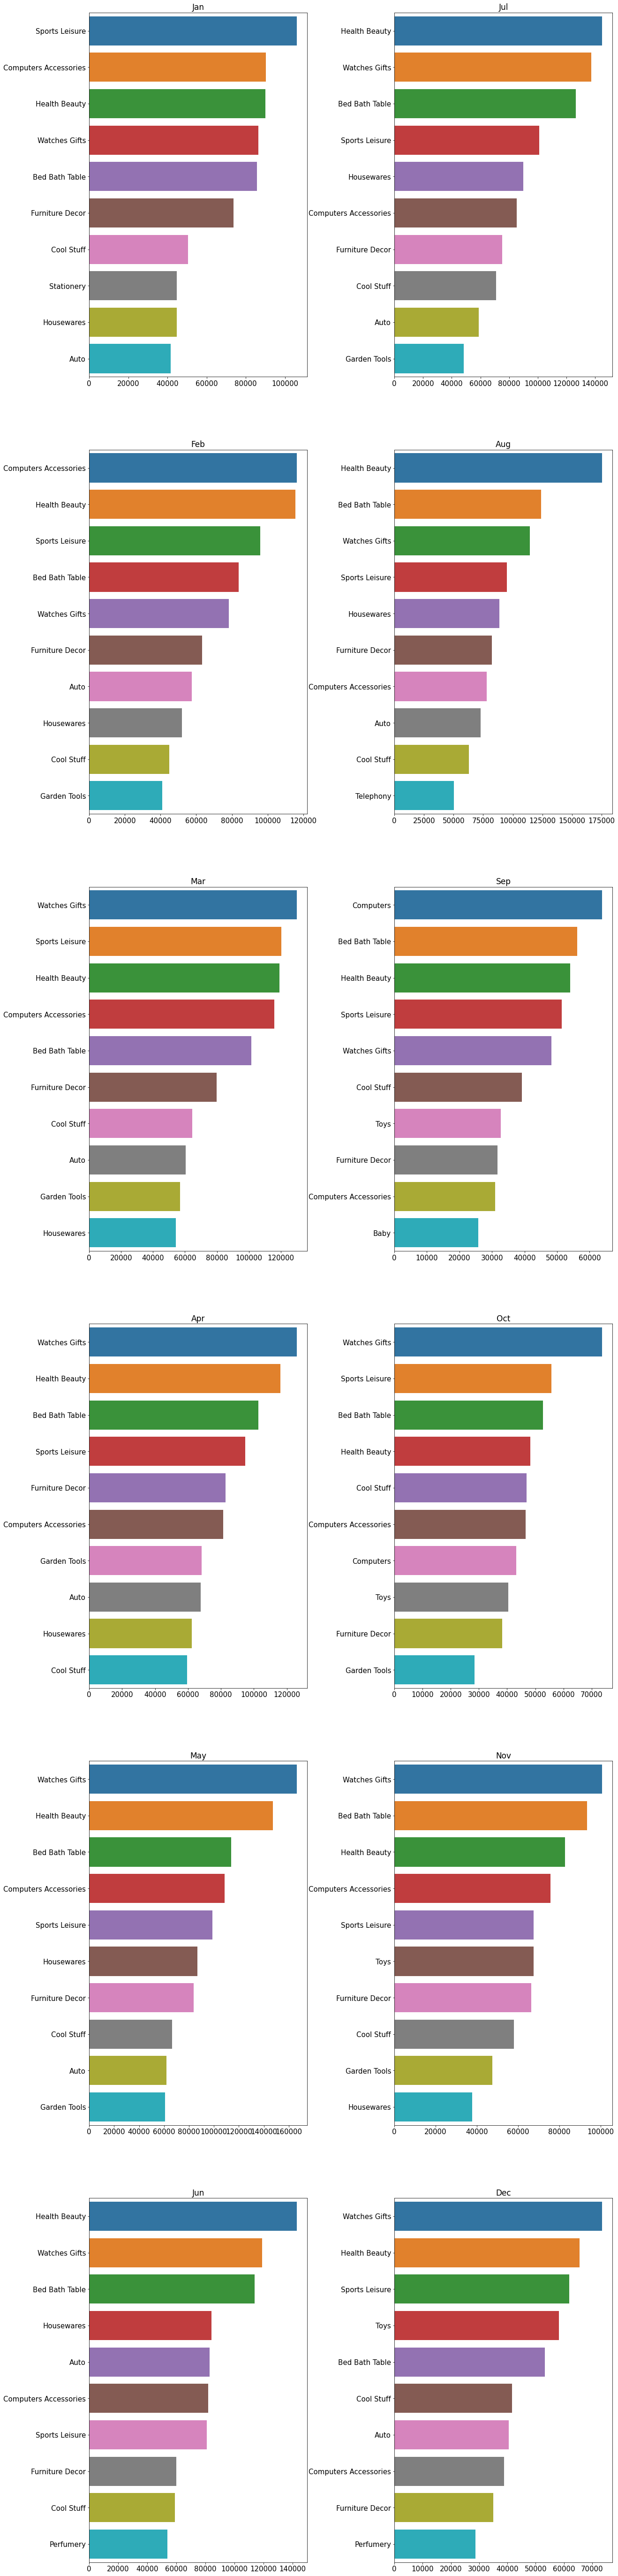

In [50]:
#Getting new DataFrames total revenue of top 10 product categories in each month
Df_jan=Df_rev_month['January'].sort_values(ascending=False)[:10]
Df_feb=Df_rev_month['February'].sort_values(ascending=False)[:10]
Df_mar=Df_rev_month['March'].sort_values(ascending=False)[:10]
Df_apr=Df_rev_month['April'].sort_values(ascending=False)[:10]
Df_may=Df_rev_month['May'].sort_values(ascending=False)[:10]
Df_jun=Df_rev_month['June'].sort_values(ascending=False)[:10]
Df_jul=Df_rev_month['July'].sort_values(ascending=False)[:10]
Df_aug=Df_rev_month['August'].sort_values(ascending=False)[:10]
Df_sep=Df_rev_month['September'].sort_values(ascending=False)[:10]
Df_oct=Df_rev_month['October'].sort_values(ascending=False)[:10]
Df_nov=Df_rev_month['November'].sort_values(ascending=False)[:10]
Df_dec=Df_rev_month['December'].sort_values(ascending=False)[:10]

#Create figsize and subplots
f, axes = plt.subplots(6,2, figsize=(20, 100 ))
plt.subplots_adjust(wspace = 0.4 ) #wspace: wide space

# Create individually barplot by Seaborn
sns.barplot(y=Df_jan.index,x=Df_jan.values,ax=axes[0,0])
sns.barplot(y=Df_feb.index,x=Df_feb.values,ax=axes[1,0])
sns.barplot(y=Df_mar.index,x=Df_mar.values,ax=axes[2,0])
sns.barplot(y=Df_apr.index,x=Df_apr.values,ax=axes[3,0])
sns.barplot(y=Df_may.index,x=Df_may.values,ax=axes[4,0])
sns.barplot(y=Df_jun.index,x=Df_jun.values,ax=axes[5,0])
sns.barplot(y=Df_jul.index,x=Df_jul.values,ax=axes[0,1])
sns.barplot(y=Df_aug.index,x=Df_aug.values,ax=axes[1,1])
sns.barplot(y=Df_sep.index,x=Df_sep.values,ax=axes[2,1])
sns.barplot(y=Df_oct.index,x=Df_oct.values,ax=axes[3,1])
sns.barplot(y=Df_nov.index,x=Df_nov.values,ax=axes[4,1])
sns.barplot(y=Df_dec.index,x=Df_dec.values,ax=axes[5,1])

#Set title and fontsize of each 
axes[0,0].set_title('Jan',fontsize=17)
axes[1,0].set_title('Feb',fontsize=17)
axes[2,0].set_title('Mar',fontsize=17)
axes[3,0].set_title('Apr',fontsize=17)
axes[4,0].set_title('May',fontsize=17)
axes[5,0].set_title('Jun',fontsize=17)
axes[0,1].set_title('Jul',fontsize=17)
axes[1,1].set_title('Aug',fontsize=17)
axes[2,1].set_title('Sep',fontsize=17)
axes[3,1].set_title('Oct',fontsize=17)
axes[4,1].set_title('Nov',fontsize=17)
axes[5,1].set_title('Dec',fontsize=17)

#Remove ylabel of each 
axes[0,0].yaxis.label.set_visible(False)
axes[1,0].yaxis.label.set_visible(False)
axes[2,0].yaxis.label.set_visible(False)
axes[3,0].yaxis.label.set_visible(False)
axes[4,0].yaxis.label.set_visible(False)
axes[5,0].yaxis.label.set_visible(False)
axes[0,1].yaxis.label.set_visible(False)
axes[1,1].yaxis.label.set_visible(False)
axes[2,1].yaxis.label.set_visible(False)
axes[3,1].yaxis.label.set_visible(False)
axes[4,1].yaxis.label.set_visible(False)
axes[5,1].yaxis.label.set_visible(False)

#Bold and custom size tick label of each
axes[0,0].tick_params(axis = 'both',  labelsize = 15)
axes[1,0].tick_params(axis = 'both',  labelsize = 15)
axes[2,0].tick_params(axis = 'both',  labelsize = 15)
axes[3,0].tick_params(axis = 'both',  labelsize = 15)
axes[4,0].tick_params(axis = 'both',  labelsize = 15)
axes[5,0].tick_params(axis = 'both',  labelsize = 15)
axes[0,1].tick_params(axis = 'both',  labelsize = 15)
axes[1,1].tick_params(axis = 'both',  labelsize = 15)
axes[2,1].tick_params(axis = 'both',  labelsize = 15)
axes[3,1].tick_params(axis = 'both',  labelsize = 15)
axes[4,1].tick_params(axis = 'both',  labelsize = 15)
axes[5,1].tick_params(axis = 'both',  labelsize = 15)

In [52]:
#Get top 10 product categories having the largest amount of selling 
Df_top20prod_numsell=Olist['order_id'].groupby(Olist['product_category_name']).count().sort_values(ascending=False)[:20]
Df_top10_list=np.array(Df_top20prod_numsell[:10].index)
Df_top10_list

array(['Bed Bath Table', 'Health Beauty', 'Sports Leisure',
       'Furniture Decor', 'Computers Accessories', 'Housewares',
       'Watches Gifts', 'Telephony', 'Garden Tools', 'Auto'], dtype=object)

In [53]:
#split number of selling in each product category, month by groupby function. After that, we unstack level 0 of index
Df_numsell_month=Olist[['order_id']].groupby([Olist['product_category_name'],Olist['order_purchase_timestamp'].map(lambda x:x.strftime('%m'))]).count().unstack(0).droplevel(axis=1,level=0)

#Get Series of top 10 product categories having the largest number of selling in each month
Df_top10_numsell_month=Df_numsell_month[Df_top10_list].stack(level=0)
Df_top10_numsell_month

order_purchase_timestamp  product_category_name
01                        Bed Bath Table           971.0
                          Health Beauty            738.0
                          Sports Leisure           769.0
                          Furniture Decor          863.0
                          Computers Accessories    773.0
                                                   ...  
12                        Housewares               306.0
                          Watches Gifts            376.0
                          Telephony                280.0
                          Garden Tools             334.0
                          Auto                     280.0
Length: 120, dtype: float64

In [65]:
indexs=Df_top10_numsell_month.index.get_level_values(0)
colors=np.array(Df_top10_numsell_month.index.get_level_values(1))
plt.figure(figsize=(16,10))

#Using plotly express library to create interactively multiple line charts of top 10 product categories having the largest number of selling in each month
fig=px.line(Df_top10_numsell_month,x=indexs,y=Df_top10_numsell_month.values,color=colors)

#Using fig.update_layout to make visualization more details and clearly
fig.update_layout(xaxis_title='Month',
                  yaxis_title='number of selling',
                  title_text='Top 10 product category having the largest amount of sales in each month',
                  legend_title_text='Product category',
                 )
fig.show()

<Figure size 1152x720 with 0 Axes>

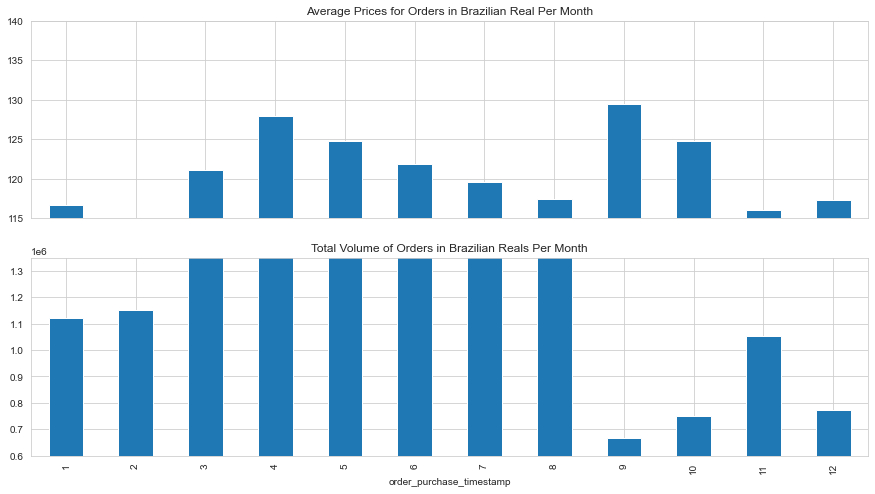

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_figheight(8)
fig.set_figwidth(15)


(Olist.groupby(Olist['order_purchase_timestamp'].dt.month)['price'].mean()
      .plot(kind='bar', ax=ax1, ylim=(115,140), 
            title='Average Prices for Orders in Brazilian Real Per Month')
)
(Olist.groupby(Olist['order_purchase_timestamp'].dt.month)['price'].sum()
      .plot(kind='bar', ax=ax2, ylim=(600000,1350000), sharex=True,
           title='Total Volume of Orders in Brazilian Reals Per Month')
)

In [58]:
# Using the API to bring the region to the data
r = requests.get('https://servicodados.ibge.gov.br/api/v1/localidades/mesorregioes')
content = [c['UF'] for c in json.loads(r.text)]
br_info = pd.DataFrame(content)
br_info['nome_regiao'] = br_info['regiao'].apply(lambda x: x['nome'])
br_info.drop('regiao', axis=1, inplace=True)
br_info.drop_duplicates(inplace=True)

# Threting geolocations outside brazilian map

#Brazils most Northern spot is at 5 deg 16′ 27.8″ N latitude.;
geo_prep = geoloc[geoloc.geolocation_lat <= 5.27438888]
#it’s most Western spot is at 73 deg, 58′ 58.19″W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng >= -73.98283055]
#It’s most southern spot is at 33 deg, 45′ 04.21″ S Latitude.
geo_prep = geo_prep[geo_prep.geolocation_lat >= -33.75116944]
#It’s most Eastern spot is 34 deg, 47′ 35.33″ W Long.
geo_prep = geo_prep[geo_prep.geolocation_lng <=  -34.79314722]
geo_group = geo_prep.groupby(by='geolocation_zip_code_prefix', as_index=False).min()



In [59]:
Olist = Olist.merge(geo_group, how='left', left_on='customer_zip_code_prefix', 
                                        right_on='geolocation_zip_code_prefix')
Olist.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_response_time,order_purchase_year,order_purchase_month,order_purchase_dayofweek,order_purchase_hour,order_purchase_day,order_purchase_mon,order_purchase_year_month,total_value,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1,Credit Card,2,72.19,Cool Stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,Volta Redonda,SP,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,Campos Dos Goytacazes,RJ,1,2017,9,2,8,Wed,Sep,201709,72.19,28013.0,-21.842371,-41.324836,campos dos goytacazes,RJ
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,1,Boleto,1,73.86,Cool Stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,Volta Redonda,SP,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14,2017-07-17 12:50:07,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,Jatai,GO,3,2017,6,2,11,Wed,Jun,201706,73.86,75800.0,-17.899740,-51.735280,jatai,GO
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,1,Credit Card,2,83.23,Cool Stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,Volta Redonda,SP,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05,2018-06-06 21:41:12,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07,3419052c8c6b45daf79c1e426f9e9bcb,30720,Belo Horizonte,MG,1,2018,5,4,10,Fri,May,201805,83.23,30720.0,-19.922788,-43.984111,belo horizonte,MG
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,1,Credit Card,3,75.07,Cool Stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,Volta Redonda,SP,8304ff37d8b16b57086fa283fe0c44f8,5,NaN,NaN,2017-08-10,2017-08-13 03:35:17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,2017-08-01 18:55:08,2017-08-02 19:07:36,2017-08-09 21:26:33,2017-08-25,e7c828d22c0682c1565252deefbe334d,83070,Sao Jose Dos Pinhais,PR,3,2017,8,1,18,Tue,Aug,201708,75.07,83070.0,-25.532535,-49.142245,sao jose dos pinhais,PR
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,1,Credit Card,4,72.19,Cool Stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,Volta Redonda,SP,426f43a82185969503fb3c86241a9535,5,NaN,NaN,2017-08-25,2017-08-28 00:51:18,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,2017-08-10 22:05:11,2017-08-11 19:43:07,2017-08-24 20:04:21,2017-09-01,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,Conselheiro Lafaiete,MG,3,2017,8,3,21,Thu,Aug,201708,72.19,36400.0,-20.752577,-43.816128,conselheiro lafaiete,MG


In [60]:
# Filtering data between 201701 and 201808
df_orders_filt = Olist[(Olist['order_purchase_year'].astype(int) >= 2017)]
df_orders_filt = Olist[(Olist['order_purchase_year'].astype(int) <= 2018)]


# Grouping data by city (top 10)
df_cities_group = df_orders_filt.groupby(by='geolocation_city', 
                                       as_index=False).count().loc[:, ['geolocation_city', 'order_id']]
df_cities_group = df_cities_group.sort_values(by='order_id', ascending=False).reset_index(drop=True)
df_cities_group = df_cities_group.iloc[:10, :]

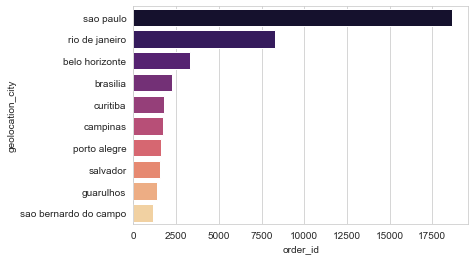

In [61]:
# Top cities with more customers orders in Brazil
sns.barplot(y='geolocation_city', x='order_id', data=df_cities_group, palette='magma');

In [62]:
# Zipping locations
lats = list(Olist.query('order_purchase_year == 2018')['geolocation_lat'].dropna().values)[:30000]
longs = list(Olist.query('order_purchase_year == 2018')['geolocation_lng'].dropna().values)[:30000]
locations = list(zip(lats, longs))

# Creating a mapa using folium
map1 = folium.Map(location=[-15, -50], zoom_start=4.0)

# Plugin: FastMarkerCluster
FastMarkerCluster(data=locations).add_to(map1)

map1

In [64]:
Olist.to_csv('./datasets/Olist_clean.csv', index = False)